# `l2hmc-qcd`

This notebook contains a minimal working example for the 4D SU(3) Model

Uses `torch.complex128` by default

## Setup

In [1]:
!python3 -m pip install torchviz --upgrade

In [2]:
import l2hmc
l2hmc.__file__

'/Users/samforeman/projects/saforem2/l2hmc-qcd/src/l2hmc/__init__.py'

In [3]:
import tensorflow as tf

In [4]:
import lovely_tensors as lt
lt.monkey_patch()
lt.set_config(color=False)

In [5]:
#! nvidia-smi | tail --lines -7

In [6]:
# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [7]:
import os
# --------------------------------------
# BE SURE TO GRAB A FRESH GPU !
#os.environ['CUDA_VISIBLE_DEVICES'] = '7'
#!echo $CUDA_VISIBLE_DEVICES
# --------------------------------------

In [8]:
#devices = os.environ.get('CUDA_VISIBLE_DEVICES', None)
#print(devices)
!getconf _NPROCESSORS_ONLN

12


In [9]:
from __future__ import absolute_import, print_function, annotations, division

import warnings

import torch
from torch import autograd
import numpy as np

from hydra.core.global_hydra import GlobalHydra

warnings.filterwarnings('ignore')

os.environ['MASTER_PORT'] = '12345'
#os.environ['OMP_NUM_THREADS'] = '256'

np.set_printoptions(threshold=5)
torch.set_printoptions(threshold=5, precision=5)

In [10]:
from l2hmc.utils.dist import (
    setup_torch
)
_ = setup_torch(
    precision='float64',
    backend='DDP',
    seed=1234,
)

[07/03/23 12:57:25][INFO][dist.py:226] - Caught MASTER_PORT:12345 from environment!
[07/03/23 12:57:25][WARNING][dist.py:332] - Setting default dtype: float64
[07/03/23 12:57:25][INFO][dist.py:338] - Global Rank: 0 / 0


In [11]:
import tensorflow as tf

In [12]:
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment

import l2hmc.group.su3.pytorch.group as gpt
ptsu3 = gpt.SU3()

import l2hmc
l2hmc.__file__

'/Users/samforeman/projects/saforem2/l2hmc-qcd/src/l2hmc/__init__.py'

In [13]:
%matplotlib widget
import matplotlib.pyplot as plt

from l2hmc.common import grab_tensor, print_dict
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

from l2hmc.utils.plot_helpers import (  # noqa
    set_plot_style,
    plot_scalar,
    plot_chains,
    plot_leapfrogs
)


def plot_metrics(metrics: dict, title: Optional[str] = None):
    for key, val in metrics.items():
        fig, ax = plot_metric(val, name=key)
        if title is not None:
            ax.set_title(title)


def plot_metric(
        metric: torch.Tensor,
        name: Optional[str] = None,
):
    assert len(metric) > 0
    if isinstance(metric[0], (int, float, bool, np.floating)):
        y = np.stack(metric)
        return plot_scalar(y, ylabel=name)
    element_shape = metric[0].shape
    if len(element_shape) == 2:
        y = grab_tensor(torch.stack(metric))
        return plot_leapfrogs(y, ylabel=name)
    if len(element_shape) == 1:
        y = grab_tensor(torch.stack(metric))
        return plot_chains(y, ylabel=name)
    if len(element_shape) == 0:
        y = grab_tensor(torch.stack(metric))
        return plot_scalar(y, ylabel=name)
    raise ValueError

## Specify defaults for building Experiment

In [14]:
GlobalHydra.instance().clear()

In [15]:
DEFAULTS = {
    'save': False,
    'restore': False,
    'init_aim': False,
    'init_wandb': False,
    'use_wandb': False,
    'use_tb': False,
    'backend': 'DDP',
    'framework': 'pytorch',
    'conv': 'none',
    'network': {
        'use_batch_norm': False,
        'activation_fn': 'tanh',
        'dropout_prob': 0.0,
        'units': [1],
    },
    'dynamics': {
        'group': 'SU3',
        'eps': 0.1,
        'nchains': 4,
        'nleapfrog': 1,
        'verbose': True,
        'latvolume': [1, 1, 1, 1],
        'eps_fixed': True,
        'use_separate_networks': False,
        'use_split_xnets': False,
    },
    'net_weights': {
        'x': {
            's': 0.0,
            't': 0.0,
            'q': 0.0,
        },
        'v': {
            's': 1.0,
            't': 1.0,
            'q': 1.0,
        },
    },
    'loss': {
        'rmse_weight': 1.0,
        'plaq_weight': 0.0,
        'charge_weight': 0.0,
        'use_mixed_loss': False,
    },
    'steps': {
        'nera': 1,
        'nepoch': 10,
        'test': 50,
        'print': 1,
        'log': 1,
    },
    'learning_rate': {
        'lr_init': 0.00001,
        'clip_norm': 1.0,
    },
    'annealing_schedule': {
        'beta_init': 6.0,
        'beta_final': 6.0,
    },
}

In [16]:
try:
    import gc
    import GPUtil

    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    torch.clear_autocast_cache()
    GPUtil.showUtilization()
except ImportError:
    pass

## Build Experiment

In [17]:
from l2hmc.configs import dict_to_list_of_overrides
OVERRIDES = dict_to_list_of_overrides(DEFAULTS)
OVERRIDES

['save=False',
 'restore=False',
 'init_aim=False',
 'init_wandb=False',
 'use_wandb=False',
 'use_tb=False',
 'backend=DDP',
 'framework=pytorch',
 'conv=none',
 'network.use_batch_norm=False',
 'network.activation_fn=tanh',
 'network.dropout_prob=0.0',
 'network.units=[1]',
 'dynamics.group=SU3',
 'dynamics.eps=0.1',
 'dynamics.nchains=4',
 'dynamics.nleapfrog=1',
 'dynamics.verbose=True',
 'dynamics.latvolume=[1, 1, 1, 1]',
 'dynamics.eps_fixed=True',
 'dynamics.use_separate_networks=False',
 'dynamics.use_split_xnets=False',
 'net_weights.x.s=0.0',
 'net_weights.x.t=0.0',
 'net_weights.x.q=0.0',
 'net_weights.v.s=1.0',
 'net_weights.v.t=1.0',
 'net_weights.v.q=1.0',
 'loss.rmse_weight=1.0',
 'loss.plaq_weight=0.0',
 'loss.charge_weight=0.0',
 'loss.use_mixed_loss=False',
 'steps.nera=1',
 'steps.nepoch=10',
 'steps.test=50',
 'steps.print=1',
 'steps.log=1',
 'learning_rate.lr_init=1e-05',
 'learning_rate.clip_norm=1.0',
 'annealing_schedule.beta_init=6.0',
 'annealing_schedule.bet

In [22]:
from l2hmc.configs import get_experiment  # noqa
from l2hmc.configs import dict_to_list_of_overrides

GlobalHydra.instance().clear()

OVERRIDES = dict_to_list_of_overrides(DEFAULTS)

ptExpSU3 = get_experiment(
    overrides=[
        *OVERRIDES,
    ],
    build_networks=True,
)

[07/03/23 13:00:06][INFO][dist.py:226] - Caught MASTER_PORT:12345 from environment!
[07/03/23 13:00:06][INFO][dist.py:226] - Caught MASTER_PORT:12345 from environment!
[07/03/23 13:00:06][WARNING][trainer.py:443] - Using `torch.optim.Adam` optimizer
[07/03/23 13:00:06][INFO][trainer.py:291] - num_params in model: 788
[07/03/23 13:00:06][WARNING][trainer.py:259] - logging with freq 1 for wandb.watch


## Evaluate

In [23]:
state = ptExpSU3.trainer.dynamics.random_state(6.0)
x0 = state.x

In [24]:
x0.dtype

torch.complex128

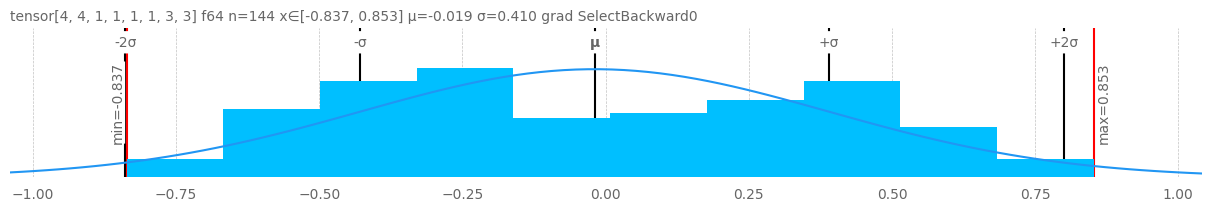

In [25]:
x0.real.plt

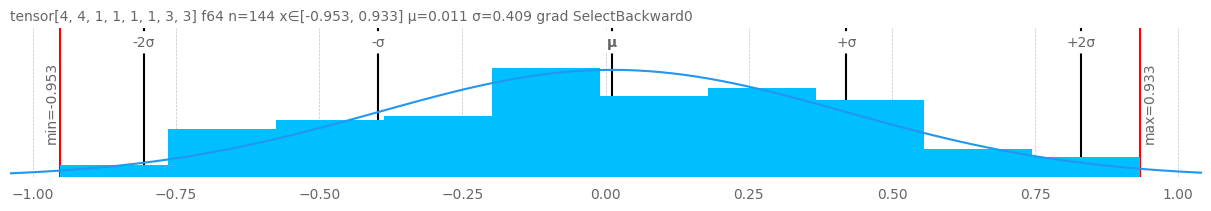

In [26]:
x0.imag.plt

In [27]:
x0v = ptExpSU3.trainer.g.group_to_vec(x0)

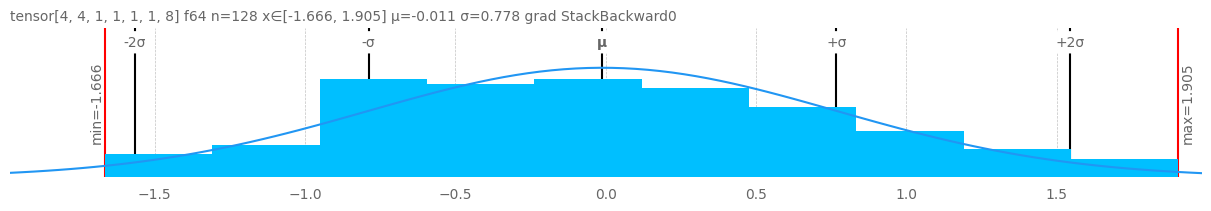

In [28]:
x0v.plt

In [29]:
from torchinfo import summary
summary(ptExpSU3.trainer.dynamics.xnet)

Layer (type:depth-idx)                   Param #
LeapfrogLayer                            --
├─Tanh: 1-1                              --
├─InputLayer: 1-2                        --
│    └─Tanh: 2-1                         --
│    └─Identity: 2-2                     --
│    └─Linear: 2-3                       73
│    └─Linear: 2-4                       73
├─ModuleList: 1-3                        --
├─ScaledTanh: 1-4                        36
│    └─Linear: 2-5                       72
├─ScaledTanh: 1-5                        36
│    └─Linear: 2-6                       72
├─Linear: 1-6                            72
├─Dropout: 1-7                           --
Total params: 434
Trainable params: 434
Non-trainable params: 0

In [30]:
summary(ptExpSU3.trainer.dynamics.vnet)

Layer (type:depth-idx)                   Param #
LeapfrogLayer                            --
├─Tanh: 1-1                              --
├─InputLayer: 1-2                        --
│    └─Tanh: 2-1                         --
│    └─Identity: 2-2                     --
│    └─Linear: 2-3                       33
│    └─Linear: 2-4                       33
├─ModuleList: 1-3                        --
├─ScaledTanh: 1-4                        36
│    └─Linear: 2-5                       72
├─ScaledTanh: 1-5                        36
│    └─Linear: 2-6                       72
├─Linear: 1-6                            72
├─Dropout: 1-7                           --
Total params: 354
Trainable params: 354
Non-trainable params: 0

In [31]:
summary(ptExpSU3.trainer.dynamics.networks)

Layer (type:depth-idx)                   Param #
ModuleDict                               --
├─LeapfrogLayer: 1-1                     --
│    └─Tanh: 2-1                         --
│    └─InputLayer: 2-2                   --
│    │    └─Tanh: 3-1                    --
│    │    └─Identity: 3-2                --
│    │    └─Linear: 3-3                  73
│    │    └─Linear: 3-4                  73
│    └─ModuleList: 2-3                   --
│    └─ScaledTanh: 2-4                   36
│    │    └─Linear: 3-5                  72
│    └─ScaledTanh: 2-5                   36
│    │    └─Linear: 3-6                  72
│    └─Linear: 2-6                       72
│    └─Dropout: 2-7                      --
├─LeapfrogLayer: 1-2                     --
│    └─Tanh: 2-8                         --
│    └─InputLayer: 2-9                   --
│    │    └─Tanh: 3-7                    --
│    │    └─Identity: 3-8                --
│    │    └─Linear: 3-9                  33
│    │    └─Linear: 3-10   

In [32]:
summary(ptExpSU3.trainer.dynamics)

Layer (type:depth-idx)                   Param #
Dynamics                                 --
├─ModuleDict: 1-1                        --
│    └─LeapfrogLayer: 2-1                --
│    │    └─Tanh: 3-1                    --
│    │    └─InputLayer: 3-2              146
│    │    └─ModuleList: 3-3              --
│    │    └─ScaledTanh: 3-4              108
│    │    └─ScaledTanh: 3-5              108
│    │    └─Linear: 3-6                  72
│    │    └─Dropout: 3-7                 --
│    └─LeapfrogLayer: 2-2                --
│    │    └─Tanh: 3-8                    --
│    │    └─InputLayer: 3-9              66
│    │    └─ModuleList: 3-10             --
│    │    └─ScaledTanh: 3-11             108
│    │    └─ScaledTanh: 3-12             108
│    │    └─Linear: 3-13                 72
│    │    └─Dropout: 3-14                --
├─LeapfrogLayer: 1-2                     (recursive)
│    └─Tanh: 2-3                         --
│    └─InputLayer: 2-4                   (recursive)
│   

### HMC

In [33]:
from l2hmc.experiment.pytorch.experiment import evaluate  # noqa

xhmc, history_hmc = evaluate(
    nsteps=100,
    exp=ptExpSU3,
    beta=6.0,
    x=x0,
    eps=0.1,
    nleapfrog=1,
    job_type='hmc',
    nlog=2,
    nprint=25,
    grab=True
)

[07/03/23 13:00:36][INFO][experiment.py:58] - Running 100 steps of hmc at beta=6.0000
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 0
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 1
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 2
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 3
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 4
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 5
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 6
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 7
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 8
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 9
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 10
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 11
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 12
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 13
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 14
[07/03/23 13:00:36][INFO][experiment.py:62] - STEP: 15
[07/03/23 13:00:36][INFO][experiment.py:62] 

In [34]:
set_plot_style()
plt.rcParams['figure.figsize'] = [12.4, 4.8]

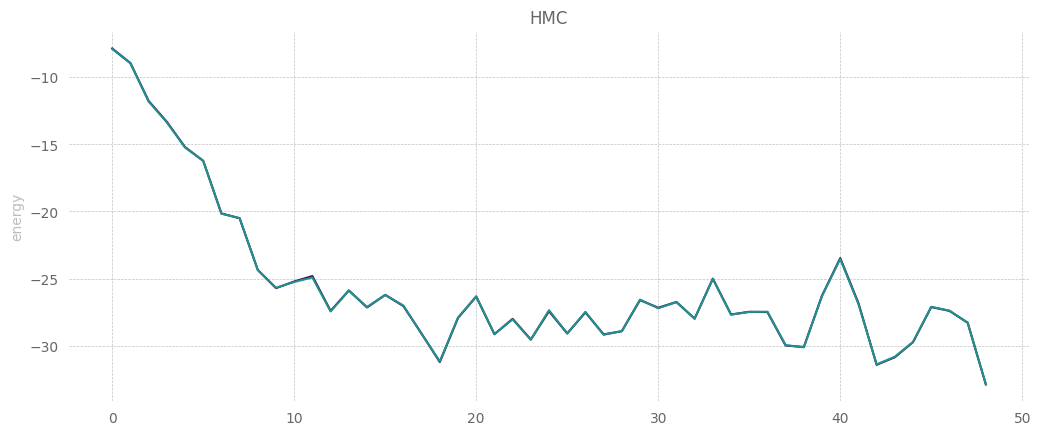

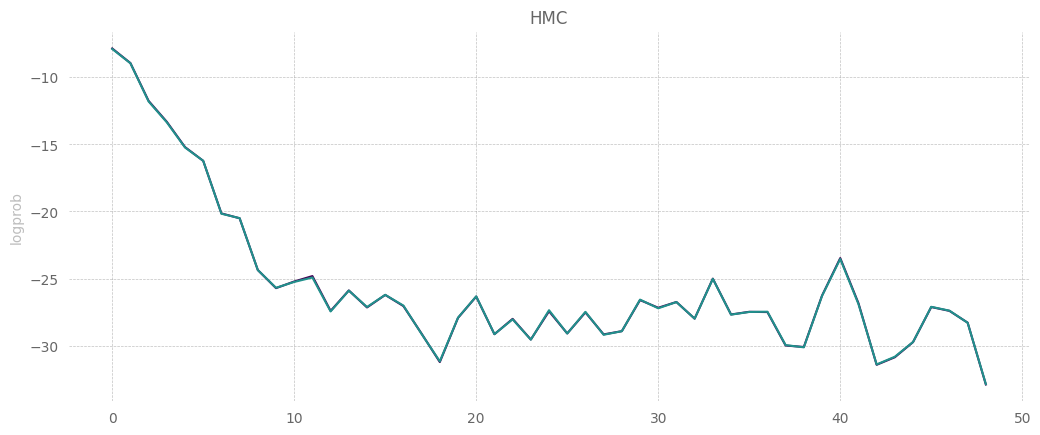

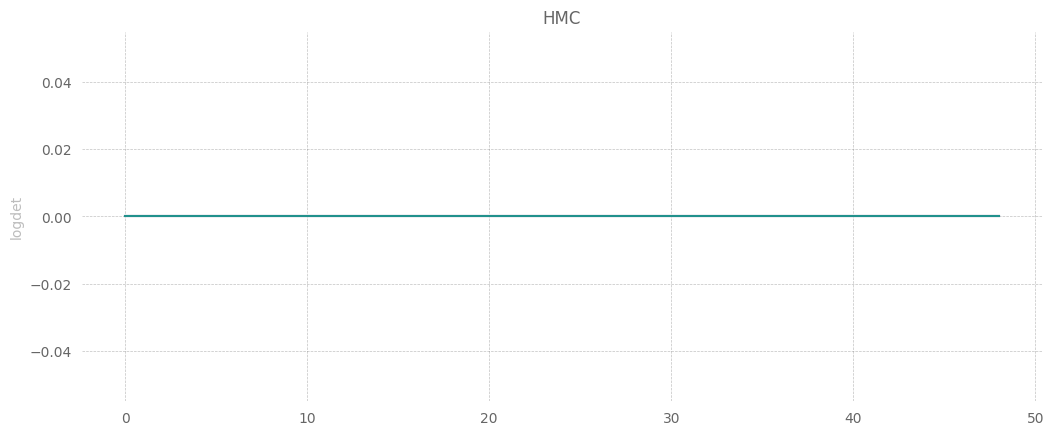

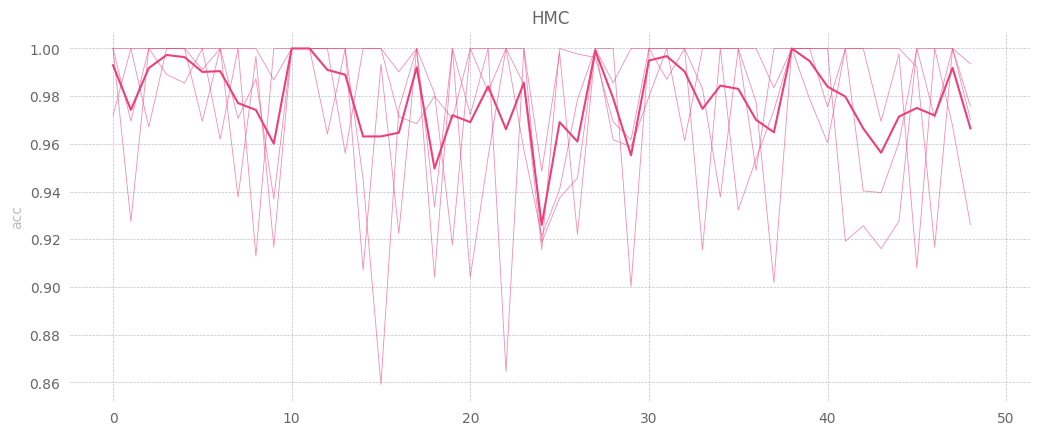

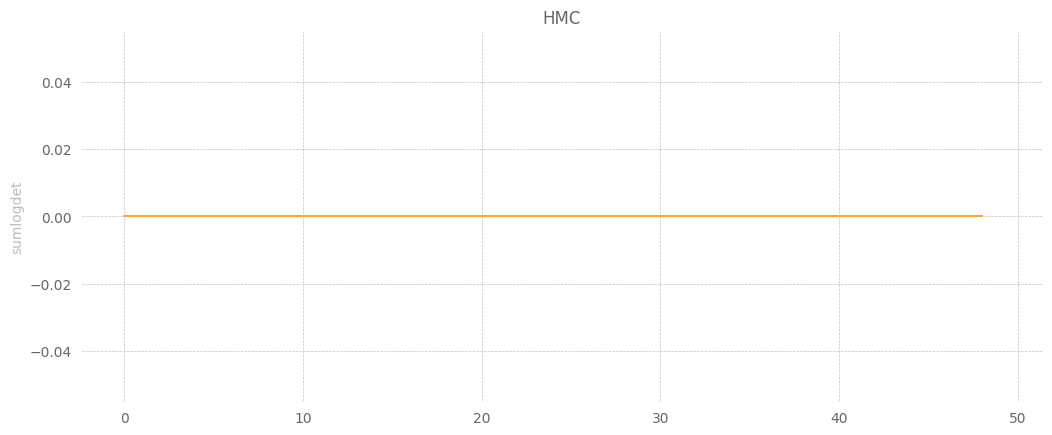

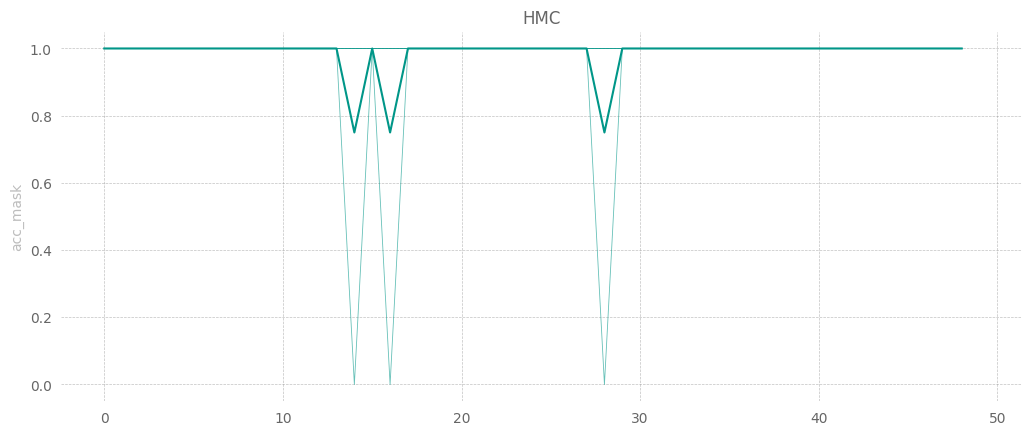

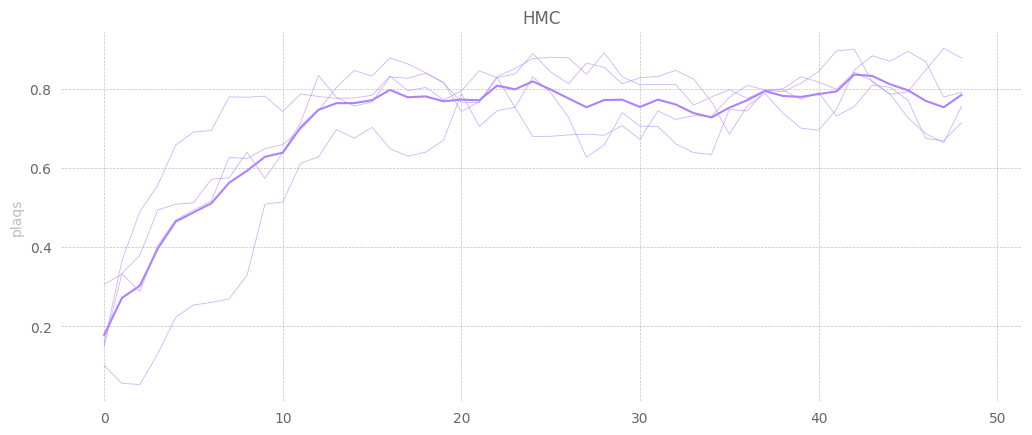

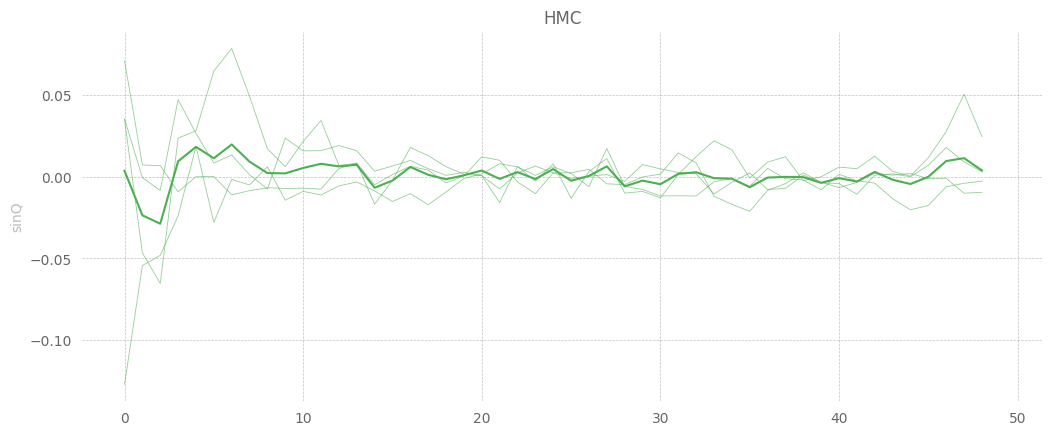

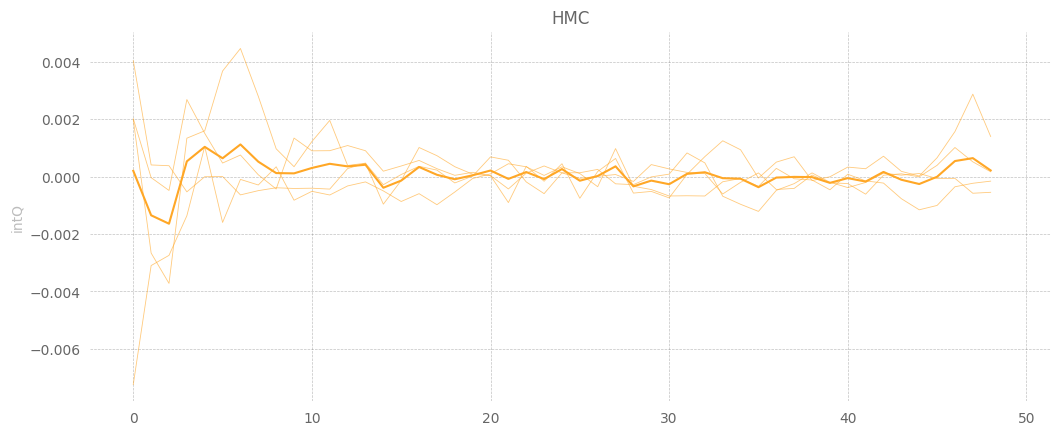

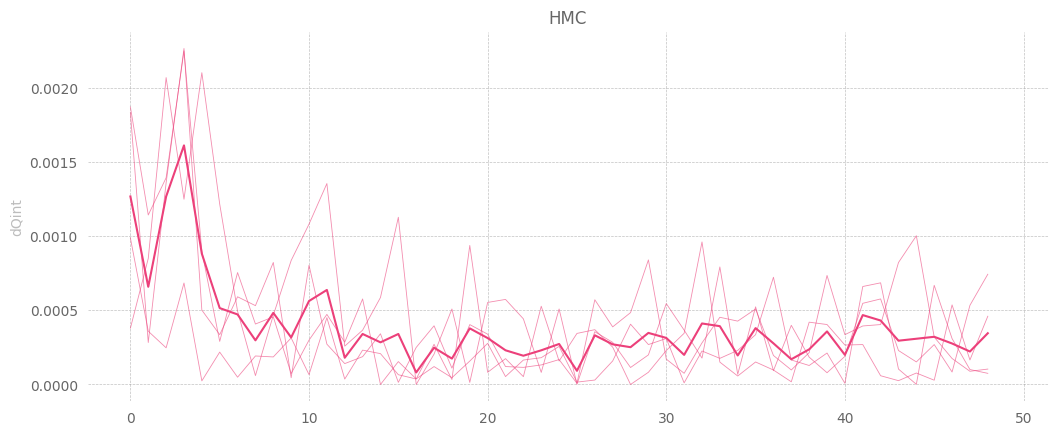

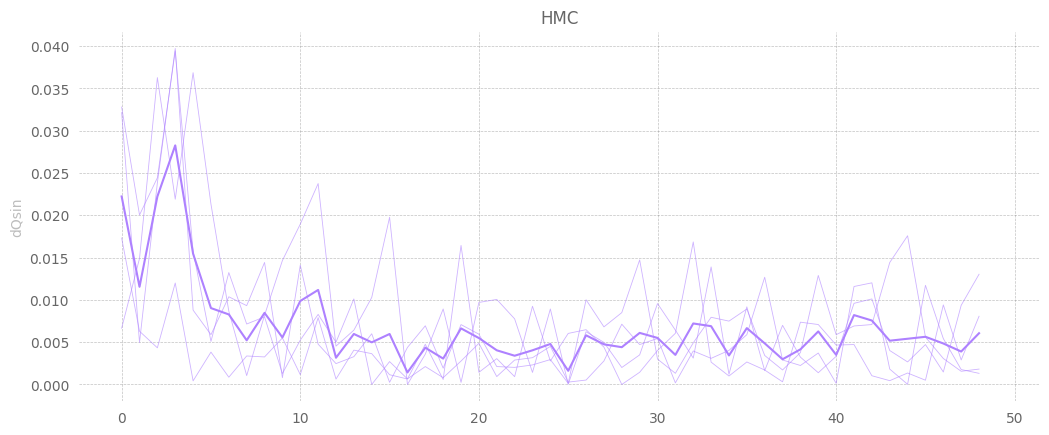

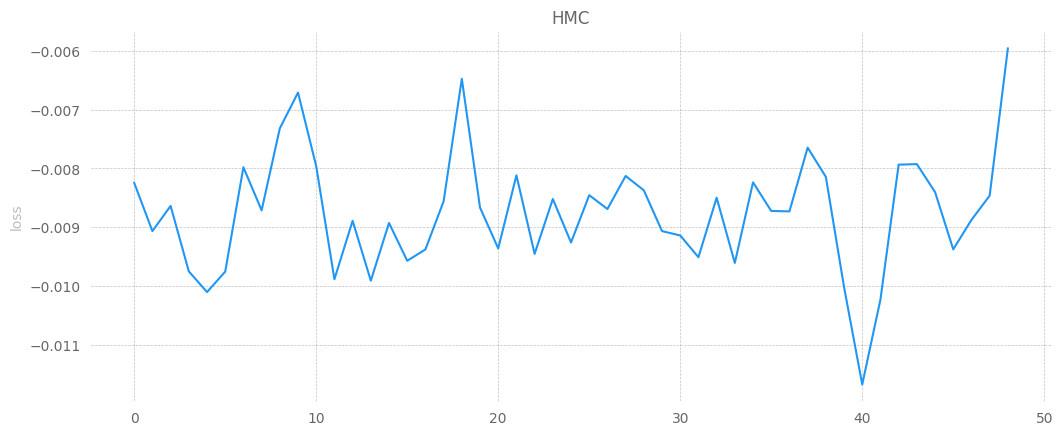

In [35]:
plot_metrics(history_hmc, title='HMC')

### Inference

In [36]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)

nlf = ptExpSU3.trainer.dynamics.config.nleapfrog
eps = torch.tensor(0.10)

#ptExpSU3.trainer.dynamics.xeps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.dynamics.veps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)

In [37]:
np.set_printoptions(precision=5)
torch.set_printoptions(precision=5)

In [38]:
_ = print_dict({
    k: v for k, v in ptExpSU3.trainer.dynamics.named_parameters()
}, grab=False)

[07/03/23 13:00:58][INFO][common.py:97] - networks.xnet.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.845e-37, 9.974e-37] μ=4.152e-38 σ=5.849e-37 grad
networks.xnet.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 grad [-6.251e-37]
networks.xnet.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.173e-37, 9.603e-37] μ=-2.884e-38 σ=5.724e-37 grad
networks.xnet.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 grad [5.711e-37]
networks.xnet.scale.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad
networks.xnet.scale.layer.weight: Parameter containing:
Parameter[36, 1] f64 x∈[-9.829e-37, 9.921e-37] μ=8.301e-38 σ=5.860e-37 grad
networks.xnet.scale.layer.bias: Parameter containing:
Parameter[36] f64 x∈[-9.693e-37, 9.050e-37] μ=-1.797e-38 σ=5.995e-37 grad
networks.xnet.transf.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad
networks.xnet.transf.layer.weight: Parameter containing:


In [39]:
from l2hmc.experiment.pytorch.experiment import evaluate  # noqa

#ptExpSU3.trainer.dynamics.init_weights()
#    #constant=np.random.randn() / 1e10
#    constant=0.0,
#)

xeval, history_eval = evaluate(
    nsteps=100,
    exp=ptExpSU3,
    beta=6.0,
    x=x0,
    job_type='eval',
    nlog=2,
    nprint=25,
    grab=True,
)

[07/03/23 13:00:59][INFO][experiment.py:58] - Running 100 steps of eval at beta=6.0000
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 0
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 1
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 2
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 3
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 4
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 5
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 6
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 7
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 8
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 9
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 10
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 11
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 12
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 13
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 14
[07/03/23 13:00:59][INFO][experiment.py:62] - STEP: 15
[07/03/23 13:00:59][INFO][experiment.py:62]

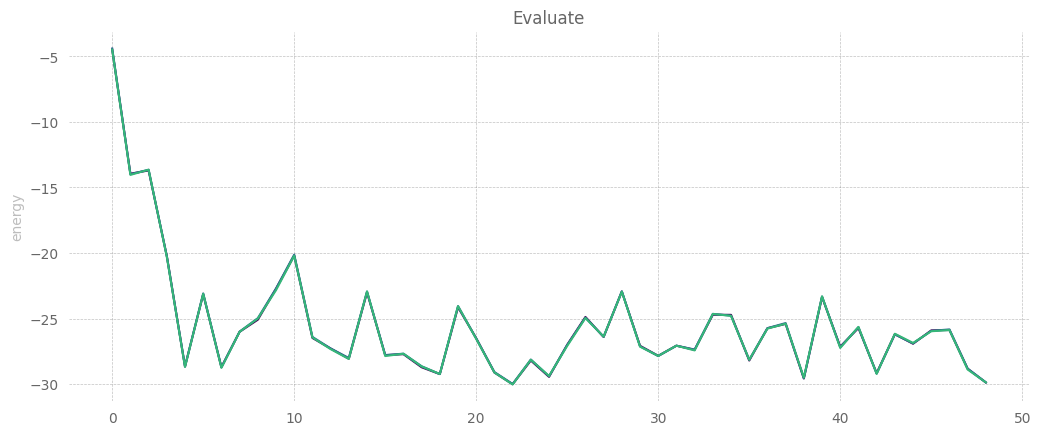

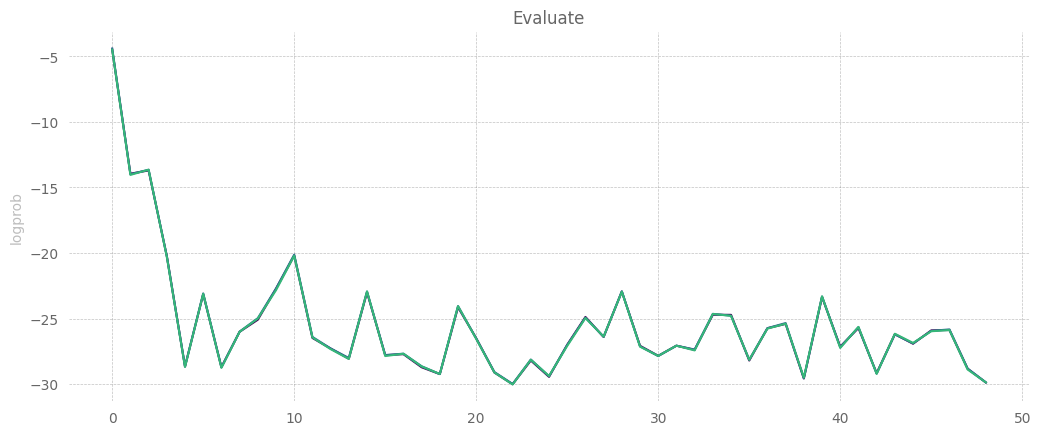

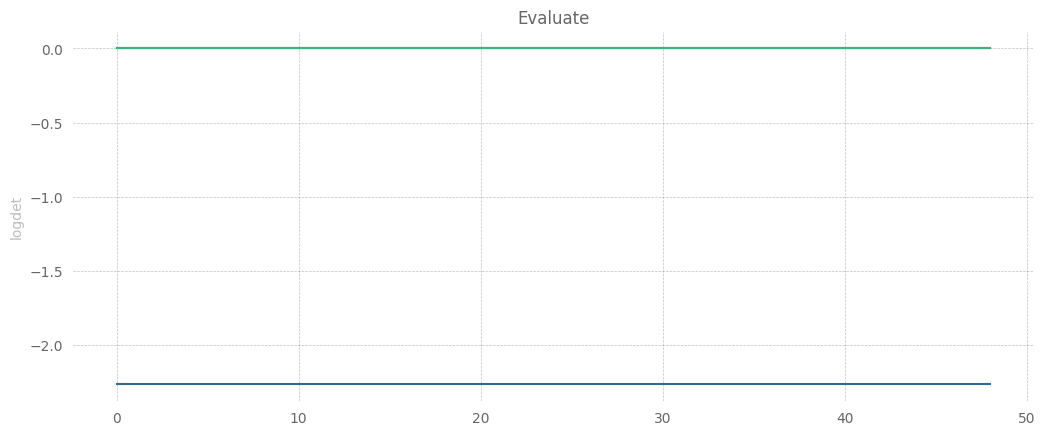

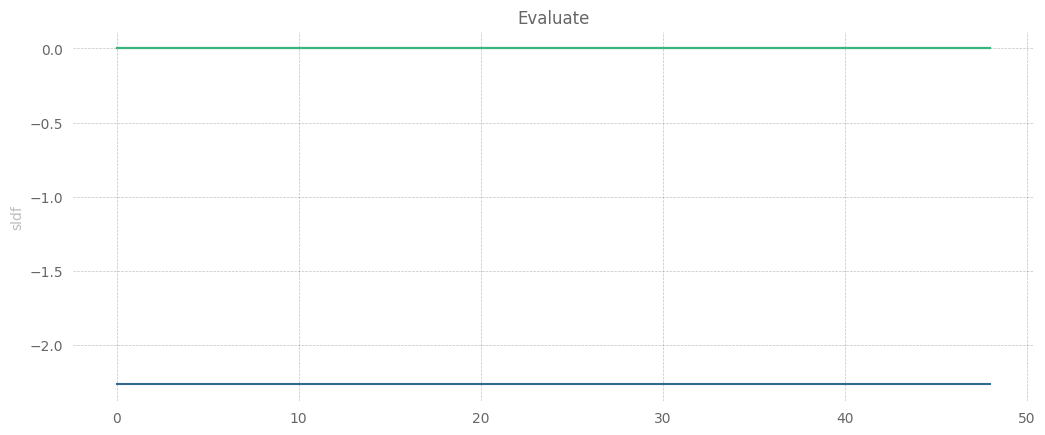

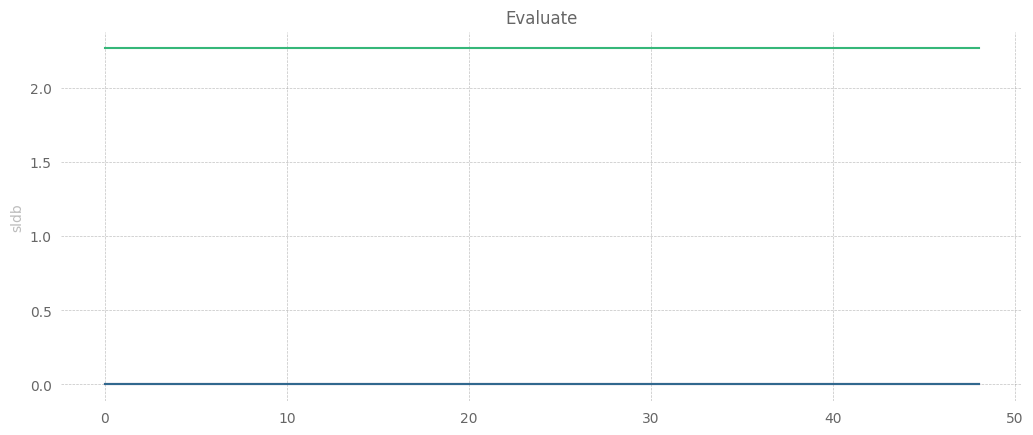

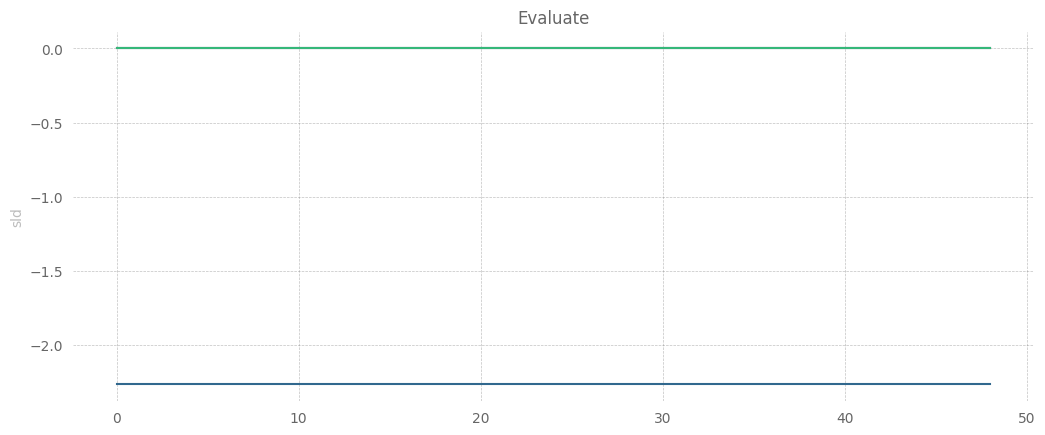

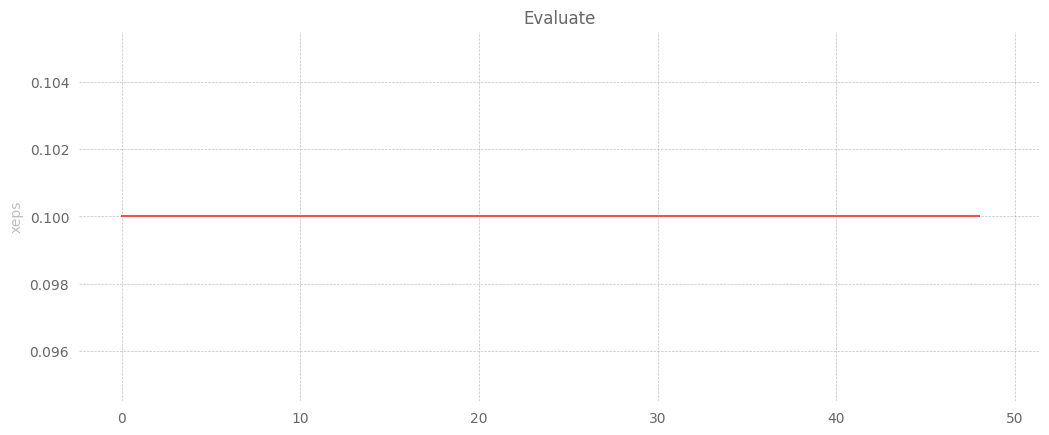

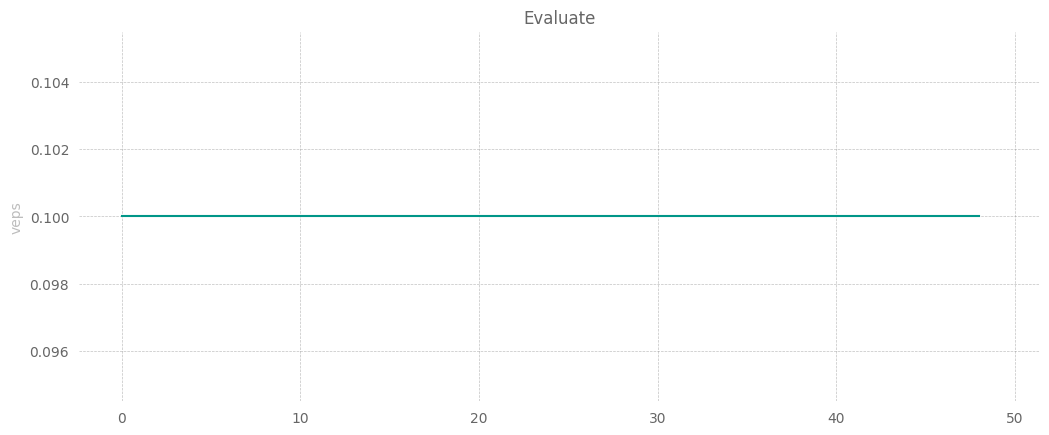

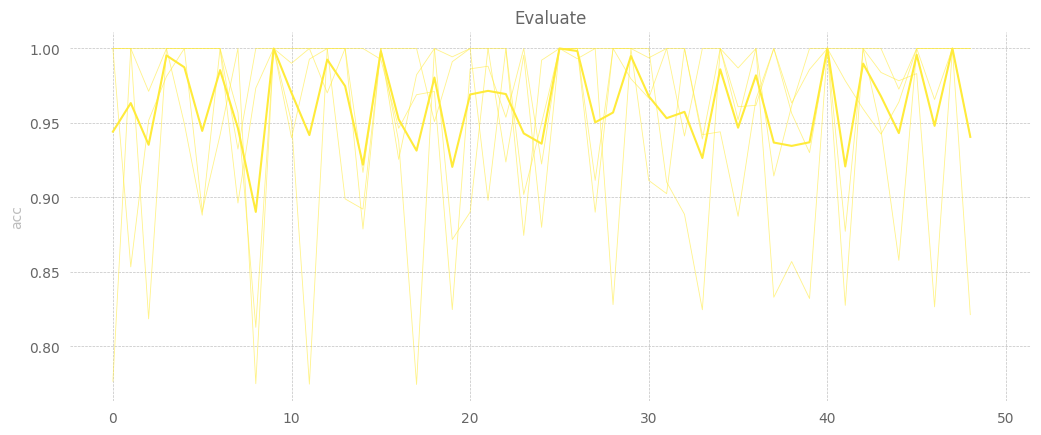

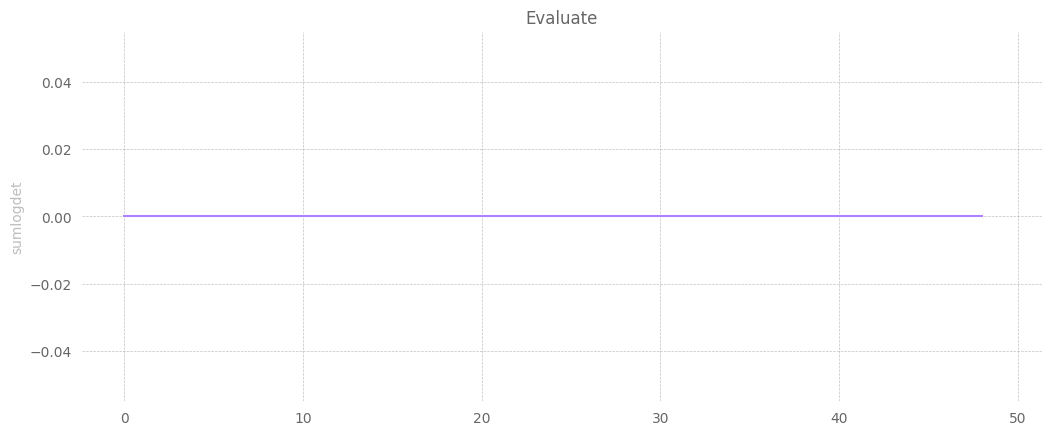

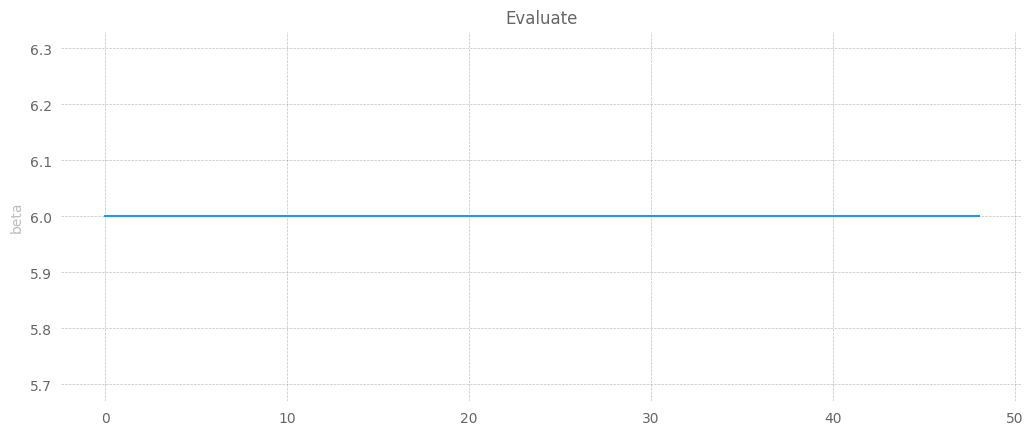

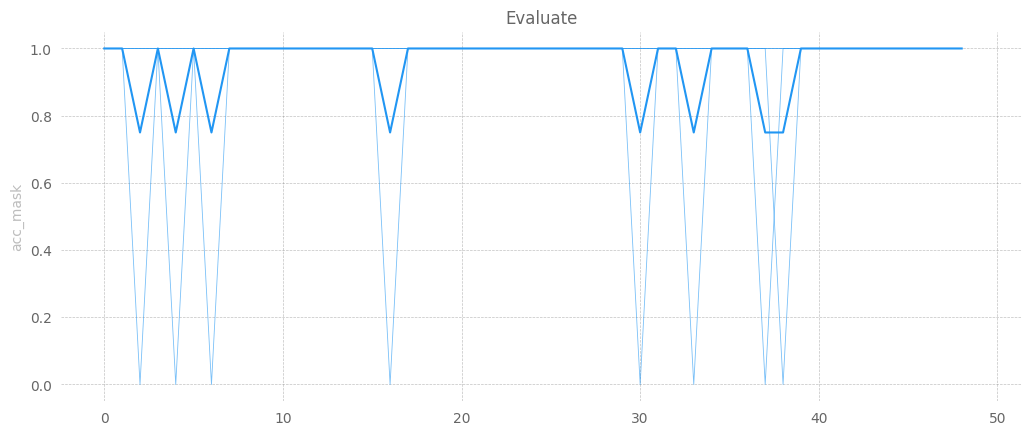

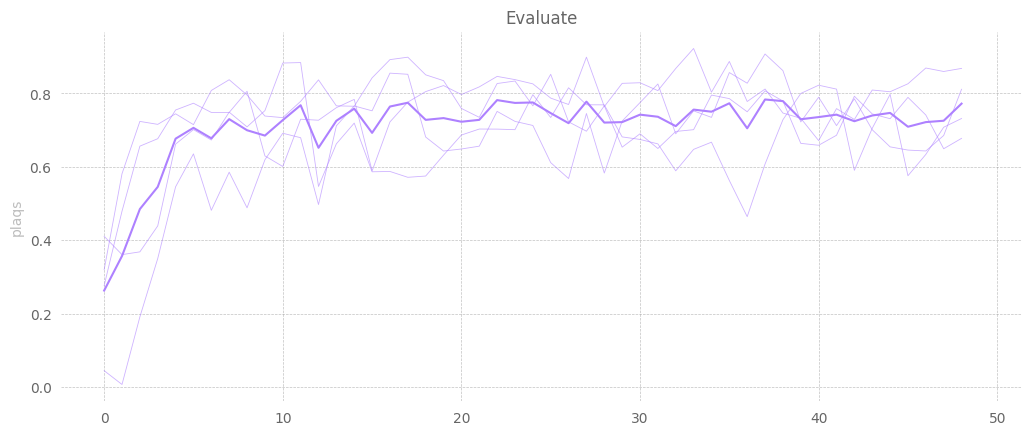

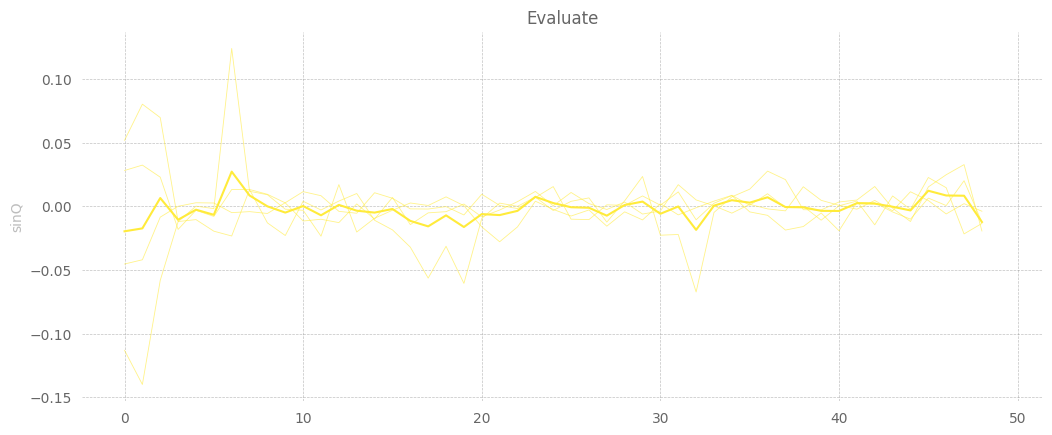

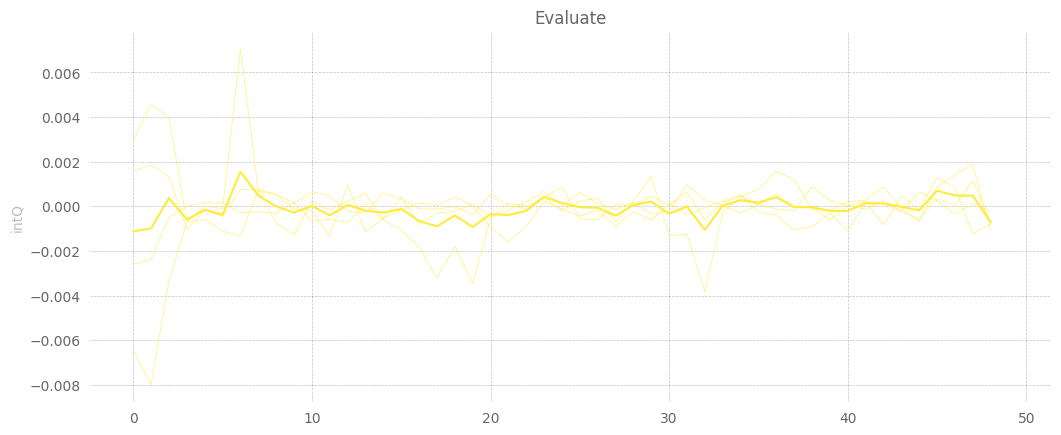

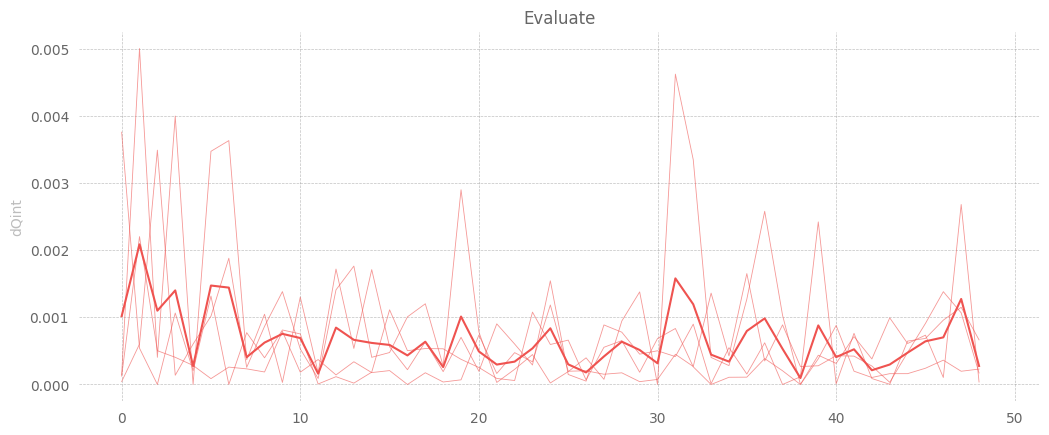

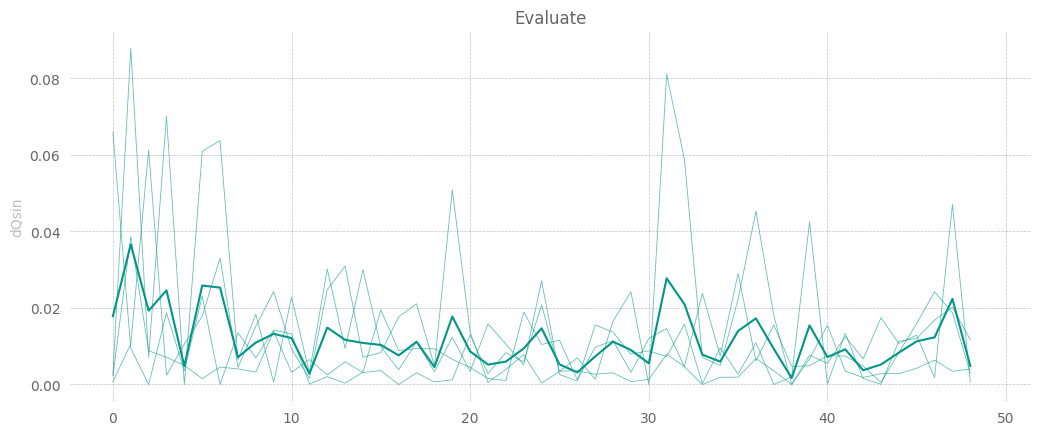

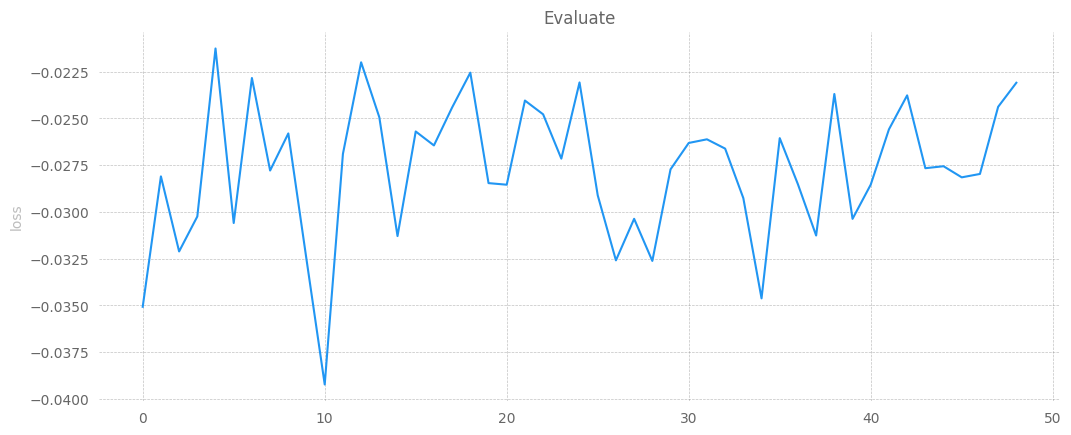

In [40]:
plot_metrics(history_eval, title='Evaluate')

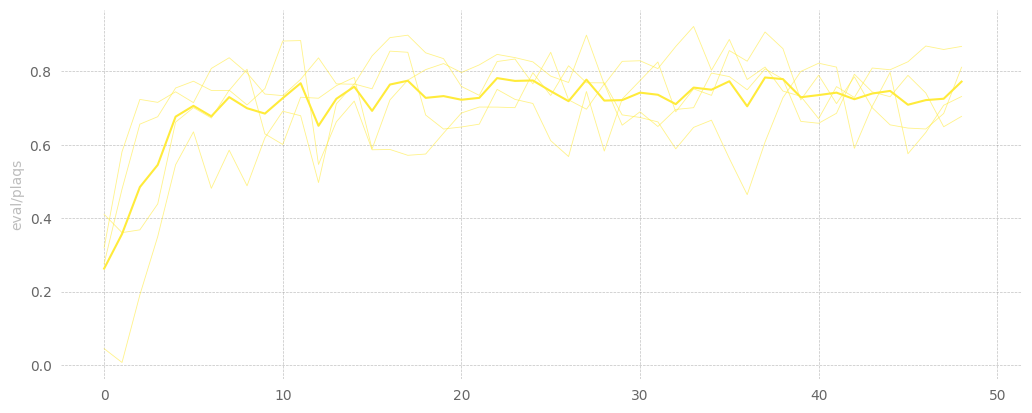

In [41]:
_ = plot_metric(history_eval['plaqs'], name='eval/plaqs')

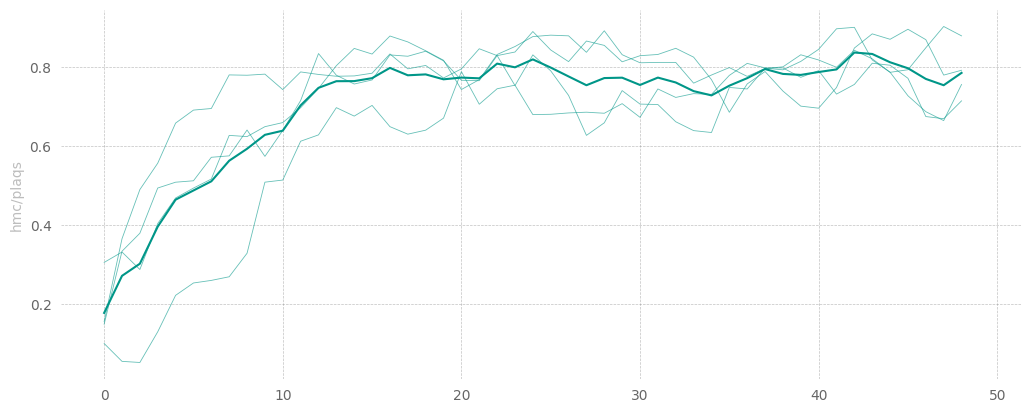

In [42]:
_ = plot_metric(history_hmc['plaqs'], name='hmc/plaqs')

In [43]:
pratio = [
    ph / pe for (pe, ph) in zip(history_hmc['plaqs'], history_eval['plaqs'])
]
pdiff = [
    (ph - pe).abs() for (pe, ph) in zip(history_hmc['plaqs'], history_eval['plaqs'])
]

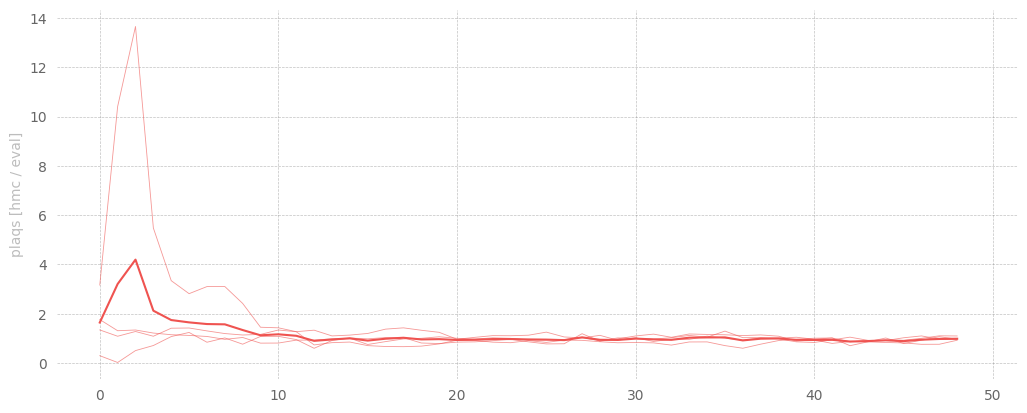

In [44]:
_ = plot_metric(pratio, name='plaqs [hmc / eval]')

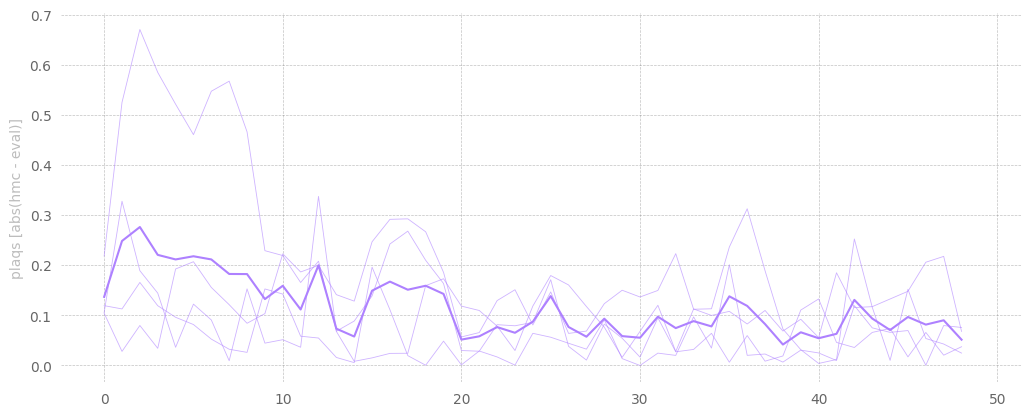

In [45]:
_ = plot_metric(pdiff, name='plaqs [abs(hmc - eval)]')

### Training

In [46]:
# backward hook with module name
def get_backward_hook(module_name: str):
    class BackwardHook:
        name: str
        def __init__(self, name):
            self.name = name
        def __call__(self, module, grad_input, grad_output):
            for i, g_in in enumerate(grad_input):
                print(module_name, torch.any(torch.isnan(g_in)))
                if torch.any(torch.isnan(g_in)):
                    print(f"{module_name}'s {i}th input gradient is nan")
            for i, g_out in enumerate(grad_output):
                if torch.any(torch.isnan(g_out)):
                    print(f"{module_name}'s {i}th output gradient is nan")
    return BackwardHook(module_name)

In [47]:
#for name, module in ptExpSU3.trainer.dynamics.named_modules():
#    module.register_full_backward_hook(get_backward_hook(name))

#model = MLP()
#batch_size = 2
# device='meta' -> no memory is consumed for visualization
#model_graph = draw_graph(model, input_size=(batch_size, 128), device='meta')
#model_graph.visual_graph

In [48]:
import graphviz
from torchview import draw_graph
graphviz.set_jupyter_format('png')

'svg'

In [49]:
from torchview import draw_graph
#state = ptExpSU3.trainer.dynamics.random_state(beta=6.0)
#x = state.x
#model_graph = draw_graph(ptExpSU3.trainer.dynamics, input_size=((8192,)))

In [50]:
xout, metrics = ptExpSU3.trainer.dynamics_engine((state.x, state.beta))

In [51]:
#from torchviz import make_dot
# make_dot(metrics['acc'], params=dict(ptExpSU3.trainer.dynamics.named_parameters()))

In [52]:
import torch
from torchview import draw_graph

from l2hmc.trainers.pytorch.trainer import Trainer  # noqa

ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)

In [53]:
def print_weights(trainer: Trainer, grab: bool = True):
    _ = print_dict({
        k: v for k, v in trainer.dynamics.named_parameters()
    })


def print_grads(trainer: Trainer, grab: bool = True):
    _ = print_dict({
        k: v.grad for k, v in trainer.dynamics.named_parameters()
    })


def print_grads_and_weights(trainer: Trainer, grab: bool = True):
    print(80 * '-')
    print('GRADS:')
    print_grads(trainer)
    print(80 * '-')
    print('WEIGHTS:')
    print_weights(trainer)
    print(80 * '-')


def calc_loss(
        x: torch.Tensor,
        y: torch.Tensor,
        acc: torch.Tensor
) -> torch.Tensor:
    dx = (x - y)
    dx2 = (dx.real.pow(2) + dx.imag.pow(2)).flatten(1)
    return (acc * dx2.mean(1)).sum()


def train_step(
        x: torch.Tensor,
        beta: float | torch.Tensor,
        trainer: Trainer,
) -> tuple[torch.Tensor, dict]:
    if isinstance(beta, float):
        beta = torch.tensor(beta)
    x.requires_grad_(True)
    trainer.optimizer.zero_grad()
    xout, metrics = trainer.dynamics_engine((x, beta))
    xprop = metrics.pop('mc_states').proposed.x
    loss = calc_loss(x, xprop, metrics['acc'])
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_norm(
        trainer.dynamics.parameters(),
        max_norm=float(1e-6),
    )
    trainer.optimizer.step()
    metrics |= {'loss': loss.item()}
    print_dict(metrics, grab=False)
    #loss = trainer.backward_step(loss)
    #dx = (x - xprop).abs().flatten(1).mean(-1)
    #loss = (metrics['acc'] * dx).mean()
    #loss = trainer.calc_loss(
    #    xinit=x,
    #    xprop=xprop,
    #    acc=metrics['acc']
    #)
    return xout.detach(), metrics

# Individual Training Step

Look at params / gradients both _before_ and _after_ a single training step

## Weights & Grads (before)

In [54]:
trainer = ptExpSU3.trainer
dynamics = trainer.dynamics
trainer.optimizer.zero_grad(set_to_none=False)
print_grads_and_weights(trainer, grab=False)

--------------------------------------------------------------------------------

GRADS:

[07/03/23 13:01:30][INFO][common.py:97] - networks.xnet.input_layer.xlayer.weight: None
networks.xnet.input_layer.xlayer.bias: None
networks.xnet.input_layer.vlayer.weight: None
networks.xnet.input_layer.vlayer.bias: None
networks.xnet.scale.coeff: None
networks.xnet.scale.layer.weight: None
networks.xnet.scale.layer.bias: None
networks.xnet.transf.coeff: None
networks.xnet.transf.layer.weight: None
networks.xnet.transf.layer.bias: None
networks.xnet.transl.weight: None
networks.xnet.transl.bias: None
networks.vnet.input_layer.xlayer.weight: None
networks.vnet.input_layer.xlayer.bias: None
networks.vnet.input_layer.vlayer.weight: None
networks.vnet.input_layer.vlayer.bias: None
networks.vnet.scale.coeff: None
networks.vnet.scale.layer.weight: None
networks.vnet.scale.layer.bias: None
networks.vnet.transf.coeff: None
networks.vnet.transf.layer.weight: None
networks.vnet.transf.layer.bias: None
networks.vnet.transl.weight: None
networks.vnet.transl.bias: None
xeps.0: None
veps.0: None


--------------------------------------------------------------------------------

WEIGHTS:

[07/03/23 13:01:30][INFO][common.py:97] - networks.xnet.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.938e-37, 9.335e-37] μ=3.670e-38 σ=5.661e-37 grad
networks.xnet.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 grad [-2.975e-37]
networks.xnet.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.329e-37, 9.561e-37] μ=-1.132e-37 σ=5.788e-37 grad
networks.xnet.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 grad [-1.407e-37]
networks.xnet.scale.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad
networks.xnet.scale.layer.weight: Parameter containing:
Parameter[36, 1] f64 x∈[-8.921e-37, 9.516e-37] μ=1.688e-37 σ=5.763e-37 grad
networks.xnet.scale.layer.bias: Parameter containing:
Parameter[36] f64 x∈[-9.307e-37, 9.756e-37] μ=-5.323e-38 σ=5.618e-37 grad
networks.xnet.transf.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad
networks.xnet.transf.layer.weight: Parameter containing:

--------------------------------------------------------------------------------

## Train Step

### Forward Step

In [55]:
from torchinfo import summary
summary(ptExpSU3.trainer.dynamics)

Layer (type:depth-idx)                   Param #
Dynamics                                 --
├─ModuleDict: 1-1                        --
│    └─LeapfrogLayer: 2-1                --
│    │    └─Tanh: 3-1                    --
│    │    └─InputLayer: 3-2              146
│    │    └─ModuleList: 3-3              --
│    │    └─ScaledTanh: 3-4              108
│    │    └─ScaledTanh: 3-5              108
│    │    └─Linear: 3-6                  72
│    │    └─Dropout: 3-7                 --
│    └─LeapfrogLayer: 2-2                --
│    │    └─Tanh: 3-8                    --
│    │    └─InputLayer: 3-9              66
│    │    └─ModuleList: 3-10             --
│    │    └─ScaledTanh: 3-11             108
│    │    └─ScaledTanh: 3-12             108
│    │    └─Linear: 3-13                 72
│    │    └─Dropout: 3-14                --
├─LeapfrogLayer: 1-2                     (recursive)
│    └─Tanh: 2-3                         --
│    └─InputLayer: 2-4                   (recursive)
│   

In [97]:
from rich import print
from torch import autograd

ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)

beta = torch.tensor(6.0)
zeros = torch.zeros_like(x0)
ones = torch.ones_like(x0)

dynamics = ptExpSU3.trainer.dynamics
config = ptExpSU3.config
g = ptExpSU3.trainer.g

x0_ = ptExpSU3.trainer.g.random(config.dynamics.xshape)
# NOTE: -----------------------------------------------
# >>> x0_.shape
# torch.Size([1, 4, 2, 2, 2, 2, 3, 3])
print(f'x0_.shape: {x0_.shape}')

avg, diff = g.checkSU(x0_)
print(f'avg: {avg}')
print(f'diff: {diff}')

trainer = ptExpSU3.trainer

with autograd.detect_anomaly(check_nan=True):
    x0_.requires_grad_(True)
    xout, metrics = trainer.dynamics_engine((x0_, beta))
    xprop = metrics.pop('mc_states').proposed.x
    _xprop = gpt.projectSU(xprop)
    loss = trainer.calc_loss(
        xinit=x0_,
        xprop=xprop,
        acc=metrics['acc']
    )
    #loss = calc_loss(x0, _xprop, metrics['acc'])
    #loss.register_hook(lambda t: print(f'hook loss = loss:\n {t}'))
    #loss.register_hook(lambda t: print(f'hook loss.grad:\n {t.grad}'))
    loss.register_hook(lambda grad: grad.clamp_(max=1.0))
    trainer.optimizer.zero_grad()
    print(loss)
    loss.backward()
    print(x0_.grad)
    torch.nn.utils.clip_grad.clip_grad_norm(
        trainer.dynamics.parameters(),
        max_norm=0.1,
    )
    trainer.optimizer.step()
    metrics |= {'loss': loss.item()}
    print_dict(metrics, grab=False)
    #xout, metrics = train_step(x=x0_, beta=beta, trainer=ptExpSU3.trainer)
    #xout, metrics = ptExpSU3.trainer.train_step((x0_, beta))
    #loss = trainer.backward_step(loss)
    #dx = (x - xprop).abs().flatten(1).mean(-1)
    #loss = (metrics['acc'] * dx).mean()
    #loss = trainer.calc_loss(
    #    xinit=x,
    #    xprop=xprop,
    #    acc=metrics['acc']
    #)

x0_.shape: torch.Size([4, 4, 1, 1, 1, 1, 3, 3])

avg: tensor[4] f64 x∈[4.240e-07, 5.823e-06] μ=2.579e-06 σ=2.336e-06 grad SqrtBackward0 
[5.823e-06, 1.483e-06, 2.588e-06, 4.240e-07]

diff: tensor[4] f64 x∈[5.743e-07, 1.162e-05] μ=5.051e-06 σ=4.757e-06 grad SqrtBackward0 
[1.162e-05, 2.901e-06, 5.105e-06, 5.743e-07]

tensor f64 grad AddBackward0 -0.031

[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 13:29:15][INFO][utils.py:259] - [hook] 1/d:
 tensor[4, 4, 1, 1, 1, 1] f64 n=16 all_zeros
[07/03/23 

RuntimeError: Function 'ReciprocalBackward0' returned nan values in its 0th output.

In [86]:
xout, metrics = ptExpSU3.trainer.train_step((x0_, beta))

RuntimeError: imag is not implemented for tensors with non-complex dtypes.

In [ ]:
beta = torch.tensor(6.0)
with autograd.detect_anomaly(check_nan=True):
    xout, metrics = train_step(x=x0, beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
from torchviz import make_dot
#if isinstance(beta, float):
#    beta = torch.tensor(beta)
#>>> with autograd.detect_anomaly():
#...     inp = torch.rand(10, 10, requires_grad=True)
#...     out = run_fn(inp)
#...     out.backward()


with autograd.detect_anomaly():
    state = ptExpSU3.trainer.dynamics.random_state(beta=6.0)
    x = state.x
    beta = state.beta
    trainer.optimizer.zero_grad(set_to_none=False)
    xout, metrics = trainer.dynamics((x, beta))
    xprop = metrics.pop('mc_states').proposed.x
    loss = calc_loss(x, xprop, metrics['acc'])
    make_dot(
        loss,
        params=dict(ptExpSU3.trainer.dynamics.named_parameters()),
        show_attrs=True,
        show_saved=True
    )
    #import pdb ; pdb.set_trace()
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_norm(
        trainer.dynamics.parameters(),
        max_norm=float(1e-16),
    )
    trainer.optimizer.step()
    metrics |= {'loss': loss.item()}
    print_dict(metrics, grab=False)

In [ ]:
make_dot(
    loss,
    params=dict(ptExpSU3.trainer.dynamics.named_parameters()),
    show_attrs=True,
    show_saved=True
)

In [ ]:
dx = (xprop - x)
dx2 = (dx.real ** 2 + dx.imag ** 2)
dx2

In [ ]:
dx2_ = (dx2.flatten(1)).sum(-1)
dx2_

In [ ]:
loss = (metrics['acc'] * dx2_).mean()

In [ ]:
loss

In [ ]:
print_grads_and_weights(trainer)

### Backward Step

In [ ]:
loss.backward()

In [ ]:
print_grads_and_weights(trainer)

In [ ]:
torch.nn.utils.clip_grad.clip_grad_norm(
    trainer.dynamics.parameters(),
    max_norm=float(1e-16),
)
trainer.optimizer.step()
metrics |= {'loss': loss.item()}
print_dict(metrics, grab=False)

In [ ]:
print_grads_and_weights(trainer, grab=False)

## Weights & Grads (after)

In [ ]:
_ = print_dict({
    k: v for k, v in dynamics.named_parameters()
}, grab=False)

In [ ]:
_ = print_dict({
    k: v.grad for k, v in dynamics.named_parameters()
}, grab=False)

In [ ]:
xout, metrics = train_step(x=x0, beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
ptExpSU3.trainer.optimizer.zero_grad()

In [ ]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)

In [ ]:
_ = print_dict({
    k: v for k, v in dynamics.named_parameters()
}, grab=False)

In [ ]:
trainer.optimizer.zero_grad()

In [ ]:
_ = print_dict({
    k: v.grad for k, v in dynamics.named_parameters()
}, grab=False)

In [ ]:
x, metrics = train_step(x=x0, beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
print_dict??

In [ ]:
_ = print_dict(
    {
        k: v.grad for k, v in dynamics.named_parameters()
    },
    grab=True,
)

In [ ]:
dynamics

In [ ]:
_ = print_dict(
    {
        k: v for k, v in dynamics.named_parameters()
    },
    grab=True,
)

In [ ]:
ptExpSU3.trainer.dynamics.init_weights(constant=0.0)

In [ ]:
ptExpSU3.trainer.optimizer.step()

In [ ]:
ptExpSU3.trainer.optimizer.zero_grad()

In [ ]:
_ = print_dict({
    k: torch.nan_to_num(v) for k, v in dynamics.named_parameters()
}, grab=True)

In [ ]:
xout, metrics = train_step(x=xinit.requires_grad_(True), beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
dynamics.networks.vnet.1.tran

In [ ]:
xout, metrics = train_step(x=xinit, beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
x = xout

In [ ]:
trainer.optimizer.zero_grad()
# xout, metrics = trainer.dynamics_engine((xinit, beta))
xout, metrics = dynamics((x, torch.tensor(beta)))

In [ ]:
xprop = dynamics.g.compat_proj(metrics.pop('mc_states').proposed.x)
loss = trainer.calc_loss(
    xinit=xinit,
    xprop=xprop,
    acc=metrics['acc']
)

In [ ]:
loss.backward()
trainer.optimizer.step()
metrics = {
    'loss': loss.item(),
    **metrics,
}
_ = print_dict(metrics, grab=True)

In [ ]:
loss

In [ ]:
_ = print_dict(metrics, grab=True)

In [ ]:
loss

In [ ]:
beta = torch.tensor(6.0)
xout1, metrics = dynamics((xout, beta))

In [ ]:
print_dict({
    k: v.grad for k, v in trainer.dynamics.named_parameters()
})
for name, param in trainer.dynamics.named_parameters():
    #print(name, torch.isnan(param.grad))
    console.print(f'{name}:\n{param.grad}')

In [ ]:
x

In [ ]:
loss

In [ ]:
trainer = ptExpSU3.trainer
dynamics = trainer.dynamics
beta = torch.tensor(6.0).to(trainer.device)

x, metrics = train_step(x=xeval, beta=beta, trainer=trainer)

In [ ]:
x, metrics = train_step(x=xhmc, beta=beta, trainer=trainer)

In [ ]:
for name, param in ptExpSU3.trainer.dynamics.named_parameters():
    #print(name, torch.isnan(param.grad))
    console.print(f'{name}: {param.grad.sum()}')

In [ ]:
loss.item()

In [ ]:
x.requires_grad_(True)
trainer.optimizer.zero_grad()
xout, metrics = trainer.dynamics_engine((x, beta))
xprop = metrics.pop('mc_states').proposed.x
ploss = trainer.calc_loss(
    xinit=x,
    xprop=xprop,
    acc=metrics['acc']
)
dx = (xprop.flatten(1) - xout.flatten(1)).abs().sum(-1)
rmse_loss = (metrics['acc'] * dx).mean()
loss = ploss + rmse_loss
loss.backward()
trainer.optimizer.step()

In [ ]:
xout, metrics = trainer.forward_step(x, beta)
xprop = metrics.pop('mc_states').proposed.x
loss = trainer.calc_loss(xinit=x, xprop=xprop, acc=metrics['acc'])
#loss = ((x - xprop) ** 2).sum()
loss

In [ ]:
x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
print_dict(metrics)

In [ ]:
from l2hmc.utils.rich import get_console
console = get_console()
for name, param in ptExpSU3.trainer.dynamics.named_parameters():
    #print(name, torch.isnan(param.grad))
    console.print(f'{name}: {param.grad}')

In [ ]:
ptExpSU3.trainer.optimizer.zero_grad()

In [ ]:
x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
print_dict(metrics)

In [ ]:
x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
print_dict(metrics)

In [ ]:
ptExpSU3.trainer.optimizer.zero_grad()

In [ ]:
from rich import print  # noqa
for name, param in ptExpSU3.trainer.dynamics.named_parameters():
    #print(name, torch.isnan(param.grad))
    print(f'{name}: {param.grad}')

In [ ]:
loss

In [ ]:
loss = trainer.backward_step(loss)

In [ ]:
loss

In [ ]:
from l2hmc.common import print_dict  # noqa

xinit = x.detach()
xout, metrics = trainer.forward_step(xinit, beta)
xprop = metrics.pop('mc_states').proposed.x
loss = trainer.calc_loss(xinit=xinit, xprop=xprop, acc=metrics['acc'])
loss = trainer.backward_step(loss)
print_dict(metrics)

In [ ]:
x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
print_dict(metrics)

In [ ]:
ptExpSU3.trainer.grad_scaler

## Train

In [ ]:
for step in range(10):
    log.info(f'Train step: {step}')
    x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
    print_dict(metrics)

In [ ]:
log.info('\n'.join([f'{k}={grab_tensor(v)}' for k, v in metrics.items()]))

In [ ]:
state = ptExpSU3.trainer.dynamics.random_state(6.0)
x, metrics = ptExpSU3.trainer.train_step_detailed(x=state.x)

In [ ]:
state = ptExpSU3.trainer.dynamics.random_state(6.0)
#x, metrics = ptExpSU3.trainer.train_step_detailed(x=state.x)
x = state.x
for _ in range(10):
    x, metrics = ptExpSU3.trainer.train_step_detailed(x=x)

In [ ]:
%matplotlib widget
import seaborn as sns
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

train_out = ptExpSU3.train(beta=6.0)

## Evaluation

In [ ]:
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

eval_out = ptExpSU3.evaluate(
    job_type='eval',
    beta=6.0,
    eval_steps=100,
    nprint=1,
)

## Generic HMC

In [ ]:
hmc_out = ptExpSU3.evaluate(
    job_type='hmc',
    beta=6.0,
    eval_steps=10,
    nprint=1,
    eps=0.075,
)